In [ ]:
# Importing numpy and functions
import numpy as np
import helpers as h
from implementations import *
import matplotlib.pyplot as plt

In [1]:
# Loading the data
X, xHeader, Y, yHeader, indexedX, indexedXheader, indexedY, indexedYheader = loadTrainingData()
print('')
# Cleaning/feature engineering the data
yClean, xClean, xHeaderClean, removedFeatures = dataCleaning(Y,X,xHeader)
print('')
# Making a balanced data set to force the model to not just predict negatively all the time
yBalanced, xBalanced, balancePrior = balanceData(yClean,xClean)
print('')
# Adding dummy variables and replacing the remaining invalid values by the mean
tx = makeTrainingData(xBalanced)
print(f'The resultant dataarray tx has shape {tx.shape}')

Data successfully loaded, there are 321 features and 328135 samples, the shapes of the unindexed data is:
y: (328135, 1), x: (328135, 321)

For a threshold of 0.7, there are 144 good features, and 177 bad features
There remains in the data 289870 samples with at most 5 missing values
The number of invalid entries remaing in the dataset is 272938
That is 0.006538802834987332 parts of the whole dataset
Removed 21050 samples with outliers more than 10 standard deviations from the mean. There remains 268820 samples in the dataset.
Standardized data by subtracting the mean and dividing by the standard deviation

Created a balanced subset of the data, with 46448 samples, 23224 each of positive and negative samples

Added dummy variable and replaced invalid entries with zeros
The resultant dataarray tx has shape (46448, 145)


In [2]:
def load_hwg_data(sub_sample=True, add_outlier=False):
    """Load data and convert it to the metric system."""
    path_dataset = "./Data/height_weight_genders.csv"
    data = np.genfromtxt(path_dataset, delimiter=",", skip_header=1, usecols=[1, 2])
    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(
        path_dataset,
        delimiter=",",
        skip_header=1,
        usecols=[0],
        converters={0: lambda x: 0 if b"Male" in x else 1},
    )
    # Convert to metric system
    height *= 0.025
    weight *= 0.454
    return height, weight, gender
height_hwg,weight_hwg,gender = load_hwg_data()
def sample_data(y, x, size_samples):
    """sample from dataset."""
    num_observations = y.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    return y[:size_samples], x[:size_samples]
def standardize(x):
    """Standardize the original data set."""
    mean_x = np.mean(x, axis=0)
    x = x - mean_x
    std_x = np.std(x, axis=0)
    x = x / std_x
    return x, mean_x, std_x

y_hwg = np.expand_dims(gender, axis=1)
X_hwg = np.c_[height_hwg.reshape(-1), weight_hwg.reshape(-1)]
y_hwg, X_hwg = sample_data(y_hwg, X_hwg, size_samples=200)
x_hwg, mean_x_hwg, std_x_hwg = standardize(X_hwg)
tx_hwg = np.c_[np.ones((y_hwg.shape[0], 1)), x_hwg]

In [3]:
# Initializing the parameters at zero and setting some constants
initial_w = np.zeros(tx.shape[1])
K = 5
gamma = 0.01
max_iter = 200

In [4]:
def determineLambda(y,tx,initial_w,lambdas):
    w_reg_logistic = np.zeros((len(lambdas),len(initial_w)),dtype=float)
    test_loss, train_loss = np.zeros(len(lambdas)), np.zeros(len(lambdas))
    for i,l in enumerate(lambdas):
        reg_logistic_regression_fixed_lambda = lambda y, tx, initial_w, max_iters, gamma: reg_logistic_regression(y,tx,l,initial_w,max_iters,gamma)
    
        w_reg_logistic[i], train_loss[i], test_loss[i] = k_fold_cross_validation(y,tx,K,initial_w,max_iter,gamma,reg_logistic_regression_fixed_lambda)
    bestLambdaIndex = np.argmin(test_loss)
    return train_loss, test_loss, lambdas[bestLambdaIndex]

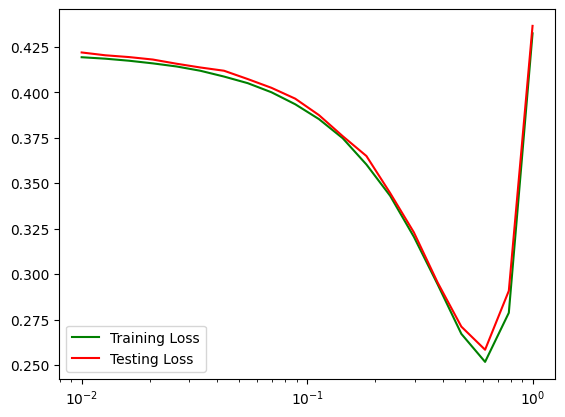

In [14]:
lambdas = np.logspace(-2,0,20)
hwg_train, hwg_test, best_lambda, best_w = determineLambda(y_hwg.flatten(),tx_hwg,np.zeros(tx_hwg.shape[1]),lambdas,max_iter,K,gamma)

plt.plot(lambdas,hwg_train,label='Training Loss', color='g')
plt.plot(lambdas,hwg_test,label='Testing Loss', color='r')
plt.xscale('log')
plt.legend()
plt.show()

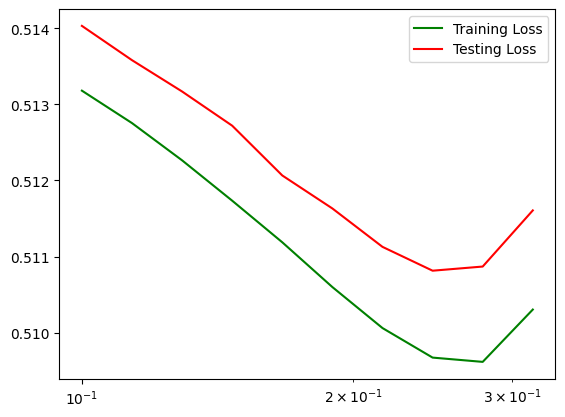

[0.51402978 0.51357956 0.51316822 0.51271923 0.5120657  0.51163245
 0.51112845 0.51081561 0.51087006 0.51160719]


In [17]:

lambdas = np.logspace(-1,-0.5,10)
train_loss, test_loss, bestLambda, best_w = determineLambda(yBalanced,tx,initial_w,lambdas,max_iter,K,gamma)

plt.plot(lambdas,train_loss,label='Training Loss', color='g')
plt.plot(lambdas,test_loss,label='Testing Loss', color='r')
plt.xscale('log')
plt.legend()
plt.show()

In [ ]:
# Training a model with gradient descent with momentum
w_gd_m, train_loss_gd_m, test_loss_gd_m = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma, mse_gd_momentum, compute_loss)
print('')
# Training a model with logistic regression
reg_logistic_regression_fixed_lambda = lambda y, tx, initial_w, max_iters, gamma: reg_logistic_regression(y,tx,bestLambda,initial_w,max_iters,gamma)
w_logistic, train_loss_logistic, test_loss_logistic = k_fold_cross_validation(yBalanced,tx,K,initial_w,max_iter,gamma,regressionFunction=reg_logistic_regression_fixed_lambda)

In [ ]:
# Loading the test data
xTest, xIndexedHeader = loadData('./Data/x_test.csv')
print(xTest.shape)

(109379, 322)


In [ ]:
# Making predictions
pred_gd = makePredictions(w_gd_m,xTest[:,1:],xHeader,xHeaderClean)
pred_logistic = makePredictions(w_logistic,xTest[:,1:],xHeader,xHeaderClean)
# Counting predicted positive cases
print(np.sum(pred_gd),np.sum(pred_logistic))


Added dummy variable and replaced invalid entries with zeros
Added dummy variable and replaced invalid entries with zeros
65969.0 45276.0


In [ ]:
pred_logistic[pred_logistic == 0] = -1
h.create_csv_submission(xTest[:,0],pred_logistic,'./Predictions/balancedDataNoPrior.csv')